#  Background bias study

Make sure the system is the expected one. 

In [1]:
from platform import python_version
import sys

print(sys.executable)
print(python_version())

/Users/chrispap/Documents/EventShapes/env.nosync/bin/python
3.9.5


Import all the necessary modules.

In [52]:
import numpy as np
import awkward as ak
import uproot
from coffea.nanoevents import NanoEventsFactory, TreeMakerSchema, BaseSchema
from coffea import processor
from coffea.nanoevents.methods import candidate
import matplotlib.pyplot as plt
import mplhep
import hist

mplhep.style.use("CMS")
ak.behavior.update(candidate.behavior)

Define event shapes functions

In [3]:
def sphericityTensor(particles):
    particles_p = np.sqrt(particles.x * particles.x + particles.y * particles.y + particles.z * particles.z)
    norm = ak.sum(particles_p * particles_p, axis=1)
    s = np.array([[
                   ak.sum(particles.x * particles.x, axis=1)/norm,
                   ak.sum(particles.x * particles.y, axis=1)/norm,
                   ak.sum(particles.x * particles.z, axis=1)/norm
                  ],
                  [
                   ak.sum(particles.y * particles.x, axis=1)/norm,
                   ak.sum(particles.y * particles.y, axis=1)/norm,
                   ak.sum(particles.y * particles.z, axis=1)/norm
                  ],
                  [
                   ak.sum(particles.z * particles.x, axis=1)/norm,
                   ak.sum(particles.z * particles.y, axis=1)/norm,
                   ak.sum(particles.z * particles.z, axis=1)/norm
                  ]])
        
    return s

def sphericity(s):
    s_eigvalues = np.sort(np.linalg.eigvals(np.moveaxis(s, 2, 0)))
    sphericity = 1.5*(s_eigvalues[:,0]+s_eigvalues[:,1])
    return sphericity

Define processor

In [6]:
class TreeMakerProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset = events.metadata['dataset']

        integratedLuminosity = 137.19*1000 # fb^{-1} to pb^{-1}
        
        ht = events.HT
        weights = integratedLuminosity*events.CrossSection[ht > 1200]/len(events)
        tracks = events.Tracks
        tracks_pt = np.sqrt(tracks.x**2 + tracks.y**2)
        tracks_eta = np.arcsinh(tracks.z / tracks_pt)
        finalTracks = (tracks_pt > 1) & (abs(tracks_eta) < 2.5) & (tracks.fromPV0 >= 2) & tracks.matchedToPFCandidate
        nTracks = ak.sum(finalTracks[ht > 1200], axis=1)
        
        # Boost to the scalar mediator's rest frame
        
        sTensor = sphericityTensor(tracks[finalTracks][ht > 1200])
        sph = sphericity(sTensor)

        outHist = (
            hist.Hist.new
            .Reg(50, 0, 250, name="nTracks")
            .Reg(50, 0, 1, name="sphericity")
            .Weight()
            .fill(
                nTracks=nTracks,
                sphericity=sph,
                weight=weights
            )
        )

        return {
            dataset: {
                "entries": len(events),
                "hist": outHist,
            }
        }


    def postprocess(self, accumulator):
        return accumulator

Run over the samples

In [23]:
baseDir = '/Users/chrispap/QCD/ak15/QCD/'
tmFileset = {
    'CMSSW': [
        baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
        baseDir + 'Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
    ],
}

tmOut = processor.run_uproot_job(
    tmFileset,
    treename="TreeMaker2/PreSelection",
    processor_instance=TreeMakerProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": TreeMakerSchema,
        "workers": 4
    },
    chunksize=50000
)
histo = tmOut['CMSSW']['hist']

Preprocessing:   0%|          | 0/8 [00:00<?, ?file/s]

Processing:   0%|          | 0/14 [00:00<?, ?chunk/s]

{'CMSSW': {'entries': 700000,
  'hist': Hist(
    Regular(50, 0, 250, name='nTracks', label='nTracks'),
    Regular(50, 0, 1, name='sphericity', label='sphericity'),
    storage=Weight()) # Sum: WeightedSum(value=2.48296e+08, variance=5.20364e+11)}}

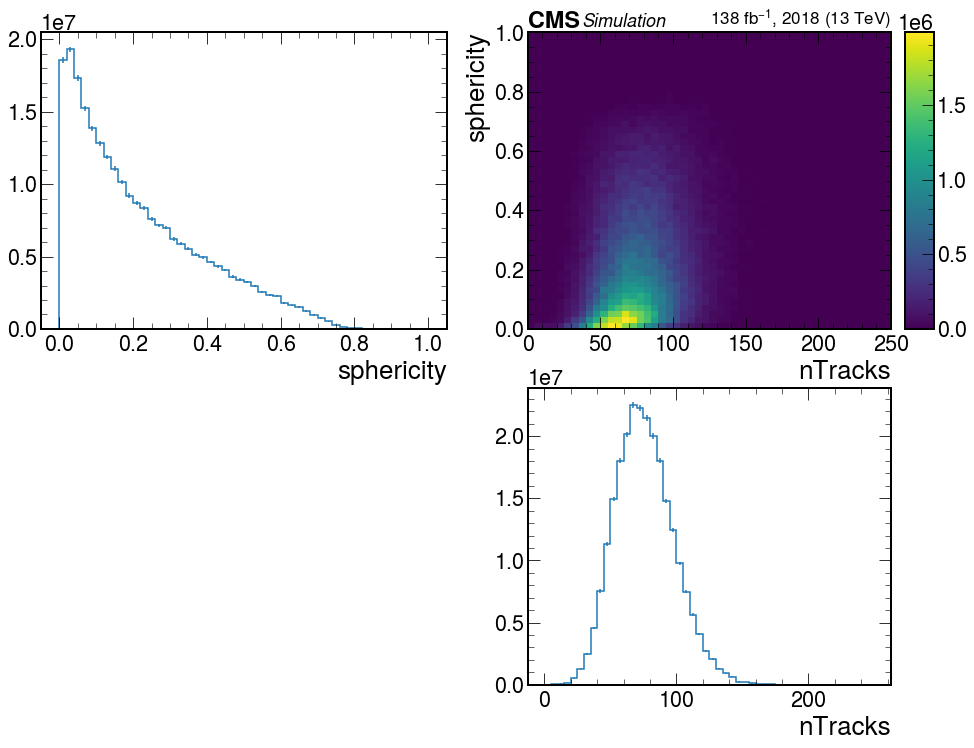

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

mplhep.histplot(histo.project("sphericity"), ax=axs[0,0])
mplhep.histplot(histo.project("nTracks"), ax=axs[1,1])
mplhep.hist2dplot(histo, ax=axs[0,1])

# Overall - both left and right annotation
mplhep.cms.label('', lumi=138, year=2018, fontsize=18)

fig.delaxes(axs[1,0])
l, b, w, h = axs[1,1].get_position().bounds
ll, bb, ww, hh = axs[0,1].get_position().bounds
axs[1,1].set_position([l, b, ww, h])

plt.show()